# Regularization

## Drop Out

```
- Nodes are randomly removed with a specified probability during training.
- It generally requires more training.
- It works better on deep networks.
- It works better with sufficient data.
```

In [1]:
# Built-in library
from typing import Any, Optional, Sequence, Union

# Standard imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt

# Black code formatter (Optional)
%load_ext lab_black
# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
# Configure the backend
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
import seaborn as sns

#### Mock Data Showing Dropout

```text
Note:
- PyTorch scales the input (node) by a factor, q
i.e.
```
$$wq$$

```text
where w = weight at the node, 
p = probability of dropout
q = scaling factor
```
$$q = \frac{1}{(1-p)}$$


In [3]:
prob = 0.5  #  probability of default
X = torch.ones(size=(15,))

# Initialize
dropout = nn.Dropout(p=prob)

# Apply dropout
# The output has been scaled up by a factor, q
y = dropout(X)

print(X)
torch.mean(X)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


tensor(1.)

In [4]:
# Elements with the value of 0 are the dropped nodes and elements
# with value of 2 are the scaled up nodes
print(y)
torch.mean(y)

tensor([2., 2., 2., 2., 0., 2., 0., 2., 2., 0., 2., 0., 2., 2., 2.])


tensor(1.4667)

In [5]:
# Dropout is turned off when evaluating the model
dropout.eval()
y = dropout(X)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


In [6]:
# OR (Using the functional implementation)
F.dropout(
    p=prob,
    input=X,
    training=False,  # apply dropout if is True
)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [7]:
# The model needs to be reset after toggling into eval mode

dropout.train()
y = dropout(X)
print(f"With dropout: {y}\n")  # with dropout

dropout.eval()
y = dropout(X)
print(f"Without dropout: {y}")  # without dropout

With dropout: tensor([2., 0., 2., 0., 2., 0., 0., 2., 2., 2., 0., 2., 0., 2., 2.])

Without dropout: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


### Example 1

```text
- Apply dropout to the training of a model.
```

In [8]:
# Create data
def create_circular_data(*, n_per_cluster: int) -> tuple[torch.Tensor, torch.Tensor]:
    """This is used to generate a 2D circular data."""

    th = np.linspace(0, 4 * np.pi, n_per_cluster)
    r1, r2 = 10, 15

    # Generate data
    a = [
        r1 * np.cos(th) + np.random.randn(n_per_cluster) * 3,
        r1 * np.sin(th) + np.random.randn(n_per_cluster),
    ]
    b = [
        r2 * np.cos(th) + np.random.randn(n_per_cluster),
        r2 * np.sin(th) + np.random.randn(n_per_cluster) * 3,
    ]

    # True labels
    labels_np = np.vstack((np.zeros((n_per_cluster, 1)), np.ones((n_per_cluster, 1))))

    # Concatanate into a matrix
    data_np = np.hstack((a, b)).T

    # Convert to a pytorch tensor
    data, labels = torch.tensor(data_np).float(), torch.tensor(labels_np).float()
    return (data, labels)

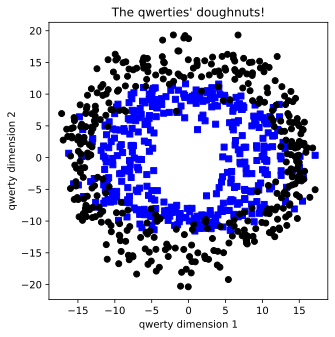

In [9]:
data, labels = create_circular_data(n_per_cluster=400)


# Visualize the data
fig = plt.figure(figsize=(5, 5))
plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], "bs")
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], "ko")
plt.title("The qwerties' doughnuts!")
plt.xlabel("qwerty dimension 1")
plt.ylabel("qwerty dimension 2")
plt.show()